[PROTECTED$11$](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb) [PROTECTED$12$](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239412-lesson-5-router)



# 路由器（Router）

## 评论（Review）

We built a graph that uses `messages` as state and a chat model with bound tools.

我们构建了一个使用 `messages` 作为状态和绑定工具的聊天模型的图。

We saw that the graph can:

我们看到图可以：

* Return a tool call
* Return a natural language response

*返回工具调用* 返回自然语言响应

## 目标（Goals）

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

我们可以将其视为一个路由器，其中聊天模型根据用户输入在直接响应或工具调用之间进行路由。

This is a simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly. 

这是一个简单的代理示例，其中 LLM 通过调用工具或直接响应来控制流程。

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

Let's extend our graph to work with either output! 

让我们扩展图表以适应任意输出！

For this, we can use two ideas:

为此，我们可以使用两种想法：

(1) Add a node that will call our tool.

(1) 添加一个将调用我们工具的节点。

(2) Add a conditional edge that will look at the chat model output, and route to our tool calling node or simply end if no tool call is performed. 

(2) 添加一个条件边，它将查看聊天模型的输出，并在未执行工具调用时路由到我们的工具调用节点或直接结束。




In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [ ]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(
    model="qwen-plus-2025-07-14",
    api_key="sk-ba2dda3817f145d7af141fdf32e31d90",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)
llm_with_tools = llm.bind_tools([multiply])

 We use the [built-in PROTECTED$11$](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it. 
 
 We use the [built-in PROTECTED$12$](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge.

我们使用 [built-in PROTECTED$11$](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) 并简单地传递一个工具列表来初始化它。  

我们使用 [built-in PROTECTED$12$](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) 作为我们的条件边。



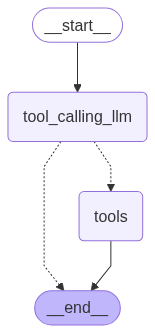

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # 如果助手（结果）的最新消息是工具调用 -> tools_condition 路由到工具
    # 如果助手（结果）的最新消息不是工具调用 -> tools_condition 路由到 END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="你好，2乘2是多少")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

你好，2乘2是多少
================================== Ai Message ==================================
Tool Calls:
  multiply (call_e026ceb409e247748786ad)
 Call ID: call_e026ceb409e247748786ad
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4


Now, we can see that the graph runs the tool!

现在，我们可以看到图运行了该工具！

It responds with a `ToolMessage`. 

它响应了一个 `ToolMessage`。

## LangGraph Studio

**⚠️ DISCLAIMER**

**⚠️ 免责声明**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

自从这些视频的拍摄以来，我们已经更新了 Studio，使其可以在本地运行并直接在浏览器中打开。这是现在运行 Studio 的首选方式（而不是像视频中那样使用桌面应用程序）。请参阅有关 [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) 本地开发服务器的文档和 [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)。要启动本地开发服务器，请在本模块的 `/studio` 目录中，在终端运行以下命令：

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

你应该看到以下输出：  
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.
Load the `router` in Studio, which uses `module-1/studio/router.py` set in `module-1/studio/langgraph.json`.

打开您的浏览器并导航到 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。  
在 Studio 中加载 `router`，它使用在 `module-1/studio/langgraph.json` 中设置的 `module-1/studio/router.py`。



In [7]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")